## import .py files in Google Colab
https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab

In [1]:
from google.colab import drive, files
drive.mount('drive')

def getLocalFiles():
    _files = files.upload()
    if _files:
        for k, v in _files.items():
            open(k, 'wb').write(v)

getLocalFiles()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


Saving data.py to data.py
Saving model.py to model.py


In [2]:
import tensorflow as tf
import numpy as np
import os
import imgaug as aug

from keras.models import load_model
from data import data_helper
from model import create_vgg19, train_model, plot_model_performance, plot_model_history

Using TensorFlow backend.


### Global variables

In [0]:
ROOT_PATH = 'drive/My Drive/master1/medical_image_recognition/'
DATASET_NAME = 'kvasir_v2'
DATASET_PATH = ROOT_PATH + 'datasets/' + DATASET_NAME + '/'
ARRAY_PATH = ROOT_PATH + 'arrays/' + DATASET_NAME + '/'
MODEL_PATH = ROOT_PATH + 'models/' + DATASET_NAME + '/'

HEIGHT, WIDTH, CHANNELS = 224, 224, 3

# the next instructions are used to make results reproducible
SEED = 1234
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
tf.set_random_seed(SEED)
aug.seed(SEED)

### Get the data class helper 

In [4]:
dataclass = data_helper(DATASET_NAME,
                        DATASET_PATH,
                        ARRAY_PATH,
                        height=HEIGHT,
                        width=WIDTH,
                        channels=CHANNELS,
                        histogram_equalization=False)

print(dataclass.directories)
print(dataclass.labels)

['test', 'train', 'val']
{'dyed-lifted-polyps': 0, 'dyed-resection-margins': 1, 'esophagitis': 2, 'normal-cecum': 3, 'normal-pylorus': 4, 'normal-z-line': 5, 'polyps': 6, 'ulcerative-colitis': 7}


### Load the data

In [5]:
#dataclass.save_images()
dataclass.get_images()

train_x = dataclass.x['train']
train_y = dataclass.y['train']
test_x  = dataclass.x['test']
test_y  = dataclass.y['test']
val_x   = dataclass.x['val']
val_y   = dataclass.y['val']

test: getting images from drive/My Drive/master1/medical_image_recognition/arrays/kvasir_v2/test(224,224,3).h5
Data shape : (1600, 224, 224, 3)
Labels shape : (1600, 8)
Found 1600 images in 13 seconds.
train: getting images from drive/My Drive/master1/medical_image_recognition/arrays/kvasir_v2/train(224,224,3).h5
Data shape : (4800, 224, 224, 3)
Labels shape : (4800, 8)
Found 4800 images in 37 seconds.
val: getting images from drive/My Drive/master1/medical_image_recognition/arrays/kvasir_v2/val(224,224,3).h5
Data shape : (1600, 224, 224, 3)
Labels shape : (1600, 8)
Found 1600 images in 19 seconds.


### Show images

In [0]:
#dataclass.show_image('train', 0)

## CNN

In [7]:
import pandas as pd
df = pd.DataFrame(train_y, columns=dataclass.labels.keys())

for column in df.columns:
    print(f'{column} : {np.array(df[df[column] == 1]).sum()}')

dyed-lifted-polyps : 600.0
dyed-resection-margins : 600.0
esophagitis : 600.0
normal-cecum : 600.0
normal-pylorus : 600.0
normal-z-line : 600.0
polyps : 600.0
ulcerative-colitis : 600.0


In [0]:
class_weight_mapping = None #{0: 1., 1: 3.}

In [11]:
# optimizers
from keras.optimizers import Adam
optimizer = Adam(lr=1e-4, decay=1e-5)

# create the model
model = create_vgg19(dataclass.num_labels,
                     include_top=True,
                     input_shape=(dataclass.height,
                                  dataclass.width,
                                  dataclass.channels),
                     num_frozen_layers=None,
                     frozen_layers=['blocks', 'fc1'],
                     optimizers=optimizer)

# paths
save_model_path = MODEL_PATH + model.name + '.hdf5'
save_history_path = MODEL_PATH + model.name + '.history'

# training
train_model(model,
            train_x,
            train_y,
            val_x,
            val_y,
            save_model_path,
            epochs=300,
            batch_size=32,
            metric='val_loss',
            save_best_only=True,
            save_weights_only=False,
            stop_after=20,
            save_history=True,
            save_history_path=save_history_path,
            class_weight_mapping=class_weight_mapping)

Froze all blocks before classification one.
Froze fc1.
Train on 4800 samples, validate on 1600 samples
Epoch 1/300
4800/4800 [==============================] - 69s 14ms/step - loss: 3.4955 - acc: 0.3644 - val_loss: 3.6859 - val_acc: 0.3250

Epoch 00001: val_loss improved from inf to 3.68592, saving model to drive/My Drive/master1/medical_image_recognition/models/kvasir_v2/vgg19blocks_fc1.hdf5
Epoch 2/300
4800/4800 [==============================] - 69s 14ms/step - loss: 2.9639 - acc: 0.5006 - val_loss: 2.8135 - val_acc: 0.5656

Epoch 00002: val_loss improved from 3.68592 to 2.81347, saving model to drive/My Drive/master1/medical_image_recognition/models/kvasir_v2/vgg19blocks_fc1.hdf5
Epoch 3/300
4800/4800 [==============================] - 69s 14ms/step - loss: 2.8259 - acc: 0.5725 - val_loss: 2.8816 - val_acc: 0.5025

Epoch 00003: val_loss did not improve from 2.81347
Epoch 4/300
4800/4800 [==============================] - 69s 14ms/step - loss: 2.7206 - acc: 0.5900 - val_loss: 2.6869

(<keras.engine.sequential.Sequential at 0x7fc482694160>,
 <keras.callbacks.History at 0x7fc4824cd9b0>)

## Check metrics

In [0]:
model = load_model(save_model_path)

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.00      0.00      0.00       200
dyed-resection-margins       0.53      0.93      0.67       200
           esophagitis       0.80      0.52      0.63       200
          normal-cecum       0.87      0.93      0.90       200
        normal-pylorus       0.90      0.94      0.92       200
         normal-z-line       0.63      0.81      0.71       200
                polyps       0.68      0.82      0.75       200
    ulcerative-colitis       0.85      0.84      0.85       200

              accuracy                           0.72      1600
             macro avg       0.66      0.72      0.68      1600
          weighted avg       0.66      0.72      0.68      1600

Loading history from drive/My Drive/master1/medical_image_recognition/models/kvasir_v2/vgg19blocks_fc1.history


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

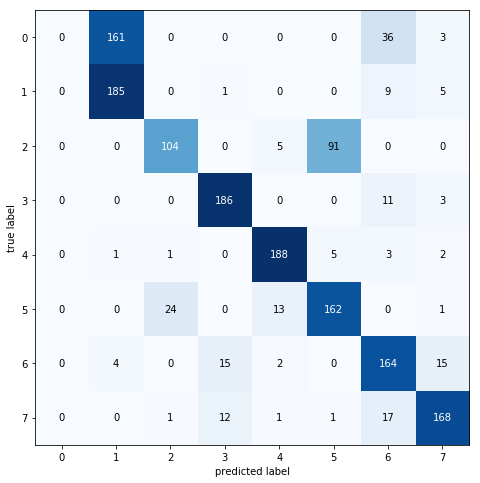

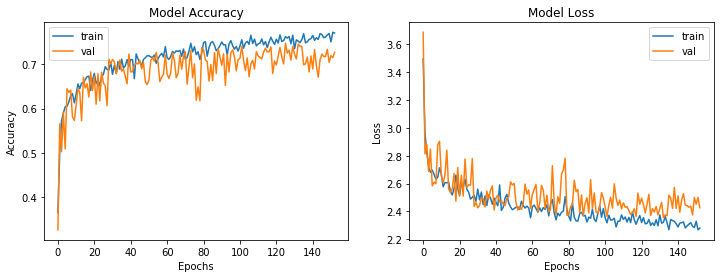

In [13]:
preds = np.argmax(model.predict(test_x), axis=-1)
ground_truth = np.argmax(test_y, axis=-1)

plot_model_performance(preds, ground_truth, dataclass.labels.keys())
plot_model_history(save_history_path)